In [1]:
%reload_ext autoreload
%autoreload 2


import sys
sys.path.append("..")

from utils.utils import load_sql_to_df, plot_history, save_to_sql
from datasets.move_as_tensor import MoveAsTensorDataset
import board_representation.board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from training.training import train_loop, test_model, Trainer
from models.move_evaluation import SentimateNet, SentimateNetSmaller, SentimateNetSkipLayer, SentimateNetWithBatchNorm
from playing.agents import *

import random

import chess
import chess.engine
from stockfish import Stockfish
import pandas as pd
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# def filter_func(row):
#     board = chess.Board(row['position'])
#     return board.is_legal(chess.Move.from_uci(row['move']))

# tables = ["classified_moves_with_comments", "chessbase_moves_with_nags", "moves_from_books", "random_moves"]
# classified_moves = [load_sql_to_df(f"SELECT position, move, sentiment FROM {table_name}", "../../chess.db") for table_name in tables]
# classified_moves = pd.concat(classified_moves)
# classified_moves = classified_moves[classified_moves.apply(filter_func, axis=1)]
# classified_moves

In [4]:
classified_moves = load_sql_to_df(f"SELECT position, move, sentiment FROM sentimate_training_set", "../../data/chess.db")
classified_moves

,position,move,sentiment
0,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,1
1,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,1
2,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,1
3,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,1
4,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,1
...,...,...,...
3881931,3q1k2/3bpnr1/2p5/3pP3/1PpP1RPP/2BR4/3K2B1/1N6 ...,c6c5,0
3881932,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR4/3K2B1/1N6 w...,g2h3,0
3881933,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 b ...,d7e8,0
3881934,3qbk2/4pnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 w -...,f4e4,0


In [4]:
# save_to_sql(classified_moves, db_filename="../../chess.db", table_name="sentimate_training_set", if_exists='replace')

In [5]:
train_df, test_df = train_test_split(classified_moves, test_size=0.005, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
1918069,6r1/1pp4k/3p2q1/p1bP3p/8/PP3QNn/1B3P1P/5R1K w ...,f3h5,0
3568093,rn1q1br1/p1pkppp1/bp6/7p/2P3n1/5PP1/PPNPP2P/R1...,d7e8,0
1894138,r4k2/5pp1/3p1b2/p2P4/5Pp1/1PPq3B/1P6/R1K3QR b ...,f6c3,1
3090538,r4k1r/1p1n1bpp/1b1pp3/pQ3p2/2PP1n2/3RPNNP/6B1/...,b6c7,0
82652,2rq1rk1/pb2ppbp/1p1p1np1/8/1n2PP2/2NB1N1P/PPPQ...,b6b5,1
...,...,...,...
2249467,8/2K5/k1N5/R7/8/8/2P5/4q3 b - - 9 9,e1a5,1
963395,4r1k1/5pp1/3r3p/Q7/1pB2q2/1P6/P1P5/1KR5 b - - ...,f4d2,1
2215104,4rq1k/6pp/p3Br2/1pbP2B1/3pQ3/2p2P2/PP4PP/RN4K1...,b2c3,1
1484405,1r3k1r/p4ppp/3b4/q2p4/3P4/1BPQP3/P3NPPP/4K2R w...,f2f3,1


,position,move,sentiment
2570947,rn2k1nr/p1pp1pp1/bp6/2qPP3/1b3P2/2N3PB/PP5P/R1...,c1d2,1
408963,2k1r3/2p3pp/pp3b2/3R4/2p5/1P2B3/P1P2PPP/5K2 w ...,f1e2,1
3695904,2b4r/3k3p/5p1P/p1pP4/1p1p2p1/2n1r1PR/PPKB1P2/N...,h1f3,0
2899843,r2R4/1b1Q1k1p/p3p1p1/1pq2p2/8/8/PPP2PPP/5BK1 b...,f7f6,1
2378474,6k1/1bp3b1/p6p/1p6/2n5/2PNK1N1/PP4q1/R1Q2R2 w ...,e3f4,1
...,...,...,...
3233703,1nbqkbnr/r2pp1pp/1p6/p1p2p2/P2P4/1P5N/2PQPPPP/...,a1a2,0
3179166,2r1k1r1/p1pp2B1/1n6/5pp1/PPP2P2/1N2PP2/B6P/R2K...,d7d6,0
3061438,6n1/5k2/3p3r/5pp1/5pb1/1P3P2/P1P1BK2/2RR4 b - ...,f7e6,0
411203,3q1rk1/5ppp/1p1N4/r1nb1B1n/3p1B2/P7/1Q3PPP/3R1...,f4e5,1


In [6]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [7]:
model = SentimateNetWithBatchNorm()
model.to(device)
model

/home/kamil/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SentimateNetWithBatchNorm(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=500, out_features=200, bias=True)
    (6): LazyBatchNorm1d(0, eps=200, momentum=0.1, affine=True, track_running_stats=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=200, o

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)
scheduler = None

In [9]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

In [10]:
test_model(test_loader, model)

Test Error: Accuracy: 63.69%, Avg loss: 0.689550


In [11]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [12]:
trainer.train(60, verbose=True)

Epoch 1/60
Train loss: 0.404480, accuracy: 83.96%
Val loss:   0.383205, accuracy: 85.23%
-----------------------------
Epoch 2/60
Train loss: 0.385865, accuracy: 84.95%
Val loss:   0.370452, accuracy: 85.87%
-----------------------------
Epoch 3/60
Train loss: 0.376759, accuracy: 85.37%
Val loss:   0.364785, accuracy: 86.04%
-----------------------------
Epoch 4/60
Train loss: 0.372129, accuracy: 85.54%
Val loss:   0.360432, accuracy: 86.23%
-----------------------------
Epoch 5/60
Train loss: 0.369227, accuracy: 85.65%
Val loss:   0.358093, accuracy: 86.24%
-----------------------------
Epoch 6/60
Train loss: 0.367236, accuracy: 85.71%
Val loss:   0.357248, accuracy: 86.28%
-----------------------------
Epoch 7/60
Train loss: 0.365700, accuracy: 85.76%
Val loss:   0.354865, accuracy: 86.34%
-----------------------------
Epoch 8/60
Train loss: 0.364240, accuracy: 85.81%
Val loss:   0.353211, accuracy: 86.34%
-----------------------------
Epoch 9/60
Train loss: 0.363248, accuracy: 85.84

In [16]:
# trainer.optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
trainer.train(20, verbose=True)

Epoch 30/49
Train loss: 0.352080, accuracy: 86.16%
Val loss:   0.344722, accuracy: 86.63%
-----------------------------
Epoch 31/49
Train loss: 0.351899, accuracy: 86.17%
Val loss:   0.343522, accuracy: 86.64%
-----------------------------
Epoch 32/49
Train loss: 0.351569, accuracy: 86.17%
Val loss:   0.344651, accuracy: 86.65%
-----------------------------
Epoch 33/49
Train loss: 0.351471, accuracy: 86.17%
Val loss:   0.342824, accuracy: 86.64%
-----------------------------
Epoch 34/49
Train loss: 0.351126, accuracy: 86.18%
Val loss:   0.347727, accuracy: 86.63%
-----------------------------
Epoch 35/49
Train loss: 0.350831, accuracy: 86.18%
Val loss:   0.342775, accuracy: 86.68%
-----------------------------
Epoch 36/49
Train loss: 0.350734, accuracy: 86.19%
Val loss:   0.342492, accuracy: 86.62%
-----------------------------
Epoch 37/49
Train loss: 0.350346, accuracy: 86.20%
Val loss:   0.344186, accuracy: 86.65%
-----------------------------
Epoch 38/49
Train loss: 0.350163, accura

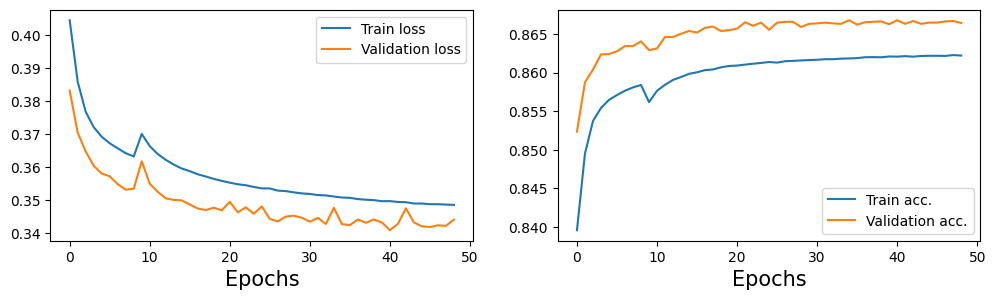

In [17]:
trainer.plot_history()

In [14]:
# test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 86.59%, Avg loss: 0.345333


In [23]:
trainer.best_model()


Loading best params on validation set (epoch 49, accuracy: 86.73%)



SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [21]:
model_2 = SentimateNetWithBatchNorm()
model_2.to(device)

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.01)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.99)

/home/kamil/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
trainer_2 = Trainer(model=model_2, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer_2, scheduler=scheduler_2, x_dtype=torch.float32, y_dtype=torch.float32)

In [23]:
trainer_2.train(100, verbose=True)

Epoch 1/100
Train loss: 0.395508, accuracy: 84.48%
Val loss:   0.370113, accuracy: 85.85%
-----------------------------
Epoch 2/100
Train loss: 0.377026, accuracy: 85.37%
Val loss:   0.362852, accuracy: 86.10%
-----------------------------
Epoch 3/100
Train loss: 0.371696, accuracy: 85.59%
Val loss:   0.358471, accuracy: 86.25%
-----------------------------
Epoch 4/100
Train loss: 0.368749, accuracy: 85.69%
Val loss:   0.358386, accuracy: 86.37%
-----------------------------
Epoch 5/100
Train loss: 0.366576, accuracy: 85.77%
Val loss:   0.354917, accuracy: 86.41%
-----------------------------
Epoch 6/100
Train loss: 0.365093, accuracy: 85.82%
Val loss:   0.353639, accuracy: 86.40%
-----------------------------
Epoch 7/100
Train loss: 0.363964, accuracy: 85.86%
Val loss:   0.354137, accuracy: 86.45%
-----------------------------
Epoch 8/100
Train loss: 0.362853, accuracy: 85.90%
Val loss:   0.351489, accuracy: 86.47%
-----------------------------
Epoch 9/100
Train loss: 0.362030, accura

In [26]:
trainer_2.optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
trainer_2.scheduler = torch.optim.lr_scheduler.StepLR(trainer_2.optimizer, step_size = 10, gamma = 0.99)
trainer_2.train(20, verbose=True)

Epoch 101/120
Train loss: 0.342996, accuracy: 86.31%
Val loss:   0.339441, accuracy: 86.67%
-----------------------------
Epoch 102/120
Train loss: 0.342690, accuracy: 86.31%
Val loss:   0.340425, accuracy: 86.69%
-----------------------------
Epoch 103/120
Train loss: 0.342491, accuracy: 86.32%
Val loss:   0.339267, accuracy: 86.68%
-----------------------------
Epoch 104/120
Train loss: 0.342297, accuracy: 86.33%
Val loss:   0.339305, accuracy: 86.69%
-----------------------------
Epoch 105/120
Train loss: 0.342181, accuracy: 86.33%
Val loss:   0.338769, accuracy: 86.72%
-----------------------------
Epoch 106/120
Train loss: 0.342092, accuracy: 86.33%
Val loss:   0.339405, accuracy: 86.69%
-----------------------------
Epoch 107/120
Train loss: 0.342023, accuracy: 86.33%
Val loss:   0.339555, accuracy: 86.70%
-----------------------------
Epoch 108/120
Train loss: 0.342116, accuracy: 86.33%
Val loss:   0.339138, accuracy: 86.70%
-----------------------------
Epoch 109/120
Train loss

In [47]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 67, accuracy: 86.73%)



In [53]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 97, accuracy: 88.32%)



In [43]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 69, accuracy: 88.32%)



In [78]:
model = SentimateNet(dropout=0)
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [80]:
trainer.train(20, verbose=True)

Epoch 1/20
Train loss: 0.378144, accuracy: 85.19%
Val loss:   0.353138, accuracy: 86.46%
-----------------------------
Epoch 2/20
Train loss: 0.347385, accuracy: 86.74%
Val loss:   0.335362, accuracy: 87.28%
-----------------------------
Epoch 3/20
Train loss: 0.333094, accuracy: 87.35%
Val loss:   0.322775, accuracy: 87.84%
-----------------------------
Epoch 4/20
Train loss: 0.323182, accuracy: 87.69%
Val loss:   0.316303, accuracy: 87.94%
-----------------------------
Epoch 5/20
Train loss: 0.315659, accuracy: 87.88%
Val loss:   0.312297, accuracy: 88.08%
-----------------------------
Epoch 6/20
Train loss: 0.309451, accuracy: 88.01%
Val loss:   0.308753, accuracy: 88.21%
-----------------------------
Epoch 7/20
Train loss: 0.304075, accuracy: 88.09%
Val loss:   0.308500, accuracy: 88.13%
-----------------------------
Epoch 8/20
Train loss: 0.298744, accuracy: 88.18%
Val loss:   0.307981, accuracy: 88.16%
-----------------------------
Epoch 9/20
Train loss: 0.293536, accuracy: 88.28

In [26]:
torch.save(model.state_dict(), "../../models/Sentimate-7.11-new-representation/last.model")
torch.save(trainer.best_model().state_dict(), "../../models/Sentimate-7.11-new-representation/best.model")


Loading best params on validation set (epoch 49, accuracy: 86.73%)



: 

In [50]:
# torch.save(model.state_dict(), "../../models/Sentimate-6.01/last.model")
torch.save(best_model.state_dict(), "../../models/Sentimate-6.14/best.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [4]:
model.load_state_dict(torch.load("../../models/Sentimate-6.05/best.model"))

<All keys matched successfully>

In [27]:
with torch.inference_mode():
    model.cpu()
    move_tensor = br.move_to_tensor(board.fen(), move).unsqueeze(0).float()
    xd = model(move_tensor)

print(xd)
# move_tensor.shape
# move_tensor.dtype

tensor([[1.6272]])


In [43]:
best_model.to(device)
test_model(test_loader, best_model)

Test Error: Accuracy: 88.32%, Avg loss: 0.300553


In [42]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [48]:
best_model.to(device)
model_agent = ModelAgent(best_model)
test_agent(model_agent, n_games=100)

100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


{'model_better': 86, 'random_better': 13, 'draw': 1}

In [39]:
model.to(device)
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:28<00:00,  1.74s/it]


{'model_better': 856, 'random_better': 122, 'draw': 22}

In [91]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:38<00:00,  1.76s/it]


{'model_better': 882, 'random_better': 101, 'draw': 17}

In [49]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:27<00:00,  1.73s/it]


{'model_better': 887, 'random_better': 92, 'draw': 21}

In [25]:
model = torch.load("../../models/Sentimate_bad.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=100)

{'model_better': 68, 'random_better': 30, 'draw': 2}

In [26]:
model = torch.load("../../models/Sentimate_good.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [28]:
test_agent(model_agent, n_games=100)

{'model_better': 62, 'random_better': 34, 'draw': 4}

In [63]:
model = SentimateNetSmaller()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSmaller(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [64]:
trainer_2 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [65]:
trainer_2.train(50, verbose=True)

Epoch 1/50
Train loss: 0.387549, accuracy: 84.75%
Val loss:   0.359533, accuracy: 86.16%
-----------------------------
Epoch 2/50
Train loss: 0.361657, accuracy: 86.13%
Val loss:   0.342334, accuracy: 87.04%
-----------------------------
Epoch 3/50
Train loss: 0.351033, accuracy: 86.66%
Val loss:   0.333993, accuracy: 87.41%
-----------------------------
Epoch 4/50
Train loss: 0.345741, accuracy: 86.90%
Val loss:   0.331138, accuracy: 87.56%
-----------------------------
Epoch 5/50
Train loss: 0.342788, accuracy: 87.03%
Val loss:   0.326798, accuracy: 87.75%
-----------------------------
Epoch 6/50
Train loss: 0.339953, accuracy: 87.15%
Val loss:   0.326296, accuracy: 87.73%
-----------------------------
Epoch 7/50
Train loss: 0.338341, accuracy: 87.21%
Val loss:   0.323304, accuracy: 87.86%
-----------------------------
Epoch 8/50
Train loss: 0.337047, accuracy: 87.26%
Val loss:   0.323195, accuracy: 87.85%
-----------------------------
Epoch 9/50
Train loss: 0.336219, accuracy: 87.28

In [66]:
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:16<00:00,  1.71s/it]


{'model_better': 869, 'random_better': 112, 'draw': 19}

In [35]:
# model = torch.load("../../models/Sentimate_smaller.model")
# random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

{'model_better': 845, 'random_better': 123, 'draw': 32}

In [77]:
model = SentimateNetSkipLayer()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSkipLayer(
  (conv1): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [80]:
trainer_3 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [81]:
trainer_3.train(50, verbose=True)

Epoch 1/50
Train loss: 0.381766, accuracy: 85.06%
Val loss:   0.358309, accuracy: 86.05%
-----------------------------
Epoch 2/50
Train loss: 0.361648, accuracy: 86.06%
Val loss:   0.348813, accuracy: 86.62%
-----------------------------
Epoch 3/50
Train loss: 0.354222, accuracy: 86.40%
Val loss:   0.342424, accuracy: 87.00%
-----------------------------
Epoch 4/50
Train loss: 0.347701, accuracy: 86.71%
Val loss:   0.336761, accuracy: 87.29%
-----------------------------
Epoch 5/50
Train loss: 0.343007, accuracy: 86.93%
Val loss:   0.333503, accuracy: 87.34%
-----------------------------
Epoch 6/50
Train loss: 0.339115, accuracy: 87.09%
Val loss:   0.331148, accuracy: 87.49%
-----------------------------
Epoch 7/50
Train loss: 0.336321, accuracy: 87.20%
Val loss:   0.328128, accuracy: 87.51%
-----------------------------
Epoch 8/50
Train loss: 0.333621, accuracy: 87.30%
Val loss:   0.324091, accuracy: 87.72%
-----------------------------
Epoch 9/50
Train loss: 0.331480, accuracy: 87.38

In [82]:
trainer_3.optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

trainer_3.train(10, verbose=True)

Epoch 51/60
Train loss: 0.306559, accuracy: 87.98%
Val loss:   0.308543, accuracy: 88.18%
-----------------------------
Epoch 52/60
Train loss: 0.306374, accuracy: 87.98%
Val loss:   0.307230, accuracy: 88.17%
-----------------------------
Epoch 53/60
Train loss: 0.305664, accuracy: 88.00%
Val loss:   0.307205, accuracy: 88.14%
-----------------------------
Epoch 54/60
Train loss: 0.305593, accuracy: 88.00%
Val loss:   0.309431, accuracy: 88.09%
-----------------------------
Epoch 55/60
Train loss: 0.305009, accuracy: 88.01%


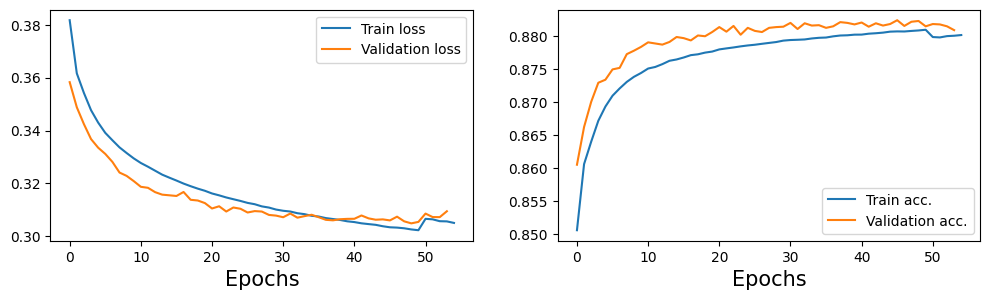

In [83]:
trainer_3.plot_history()

In [84]:
best_model_3 = trainer_3.best_model()
best_model_3_agent = ModelAgent(best_model_3)


Loading best params on validation set (epoch 46, accuracy: 88.24%)



In [86]:
test_agent(best_model_3_agent, n_games=100)

100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


{'model_better': 78, 'random_better': 20, 'draw': 2}

In [89]:
model_agent = ModelAgent(trainer.best_model())


Loading best params on validation set (epoch 6, accuracy: 88.21%)



In [90]:
test_agent(model_agent, n_games=100)

100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


{'model_better': 91, 'random_better': 7, 'draw': 2}

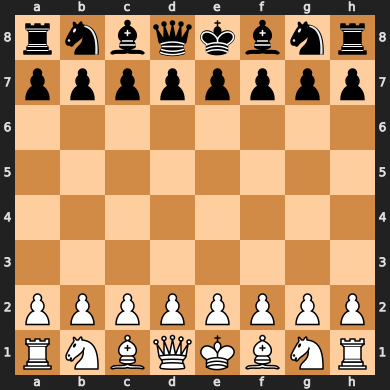

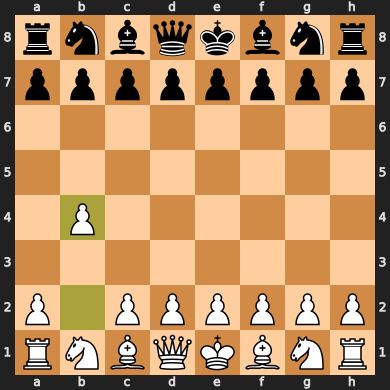

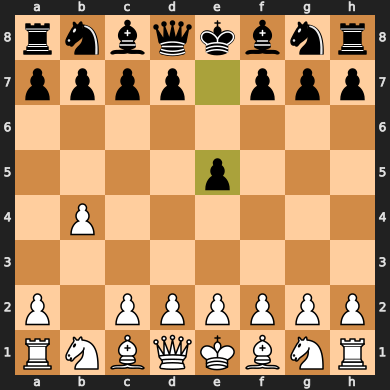

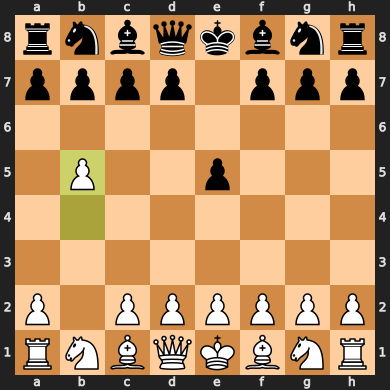

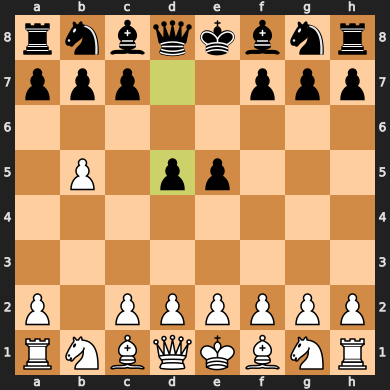

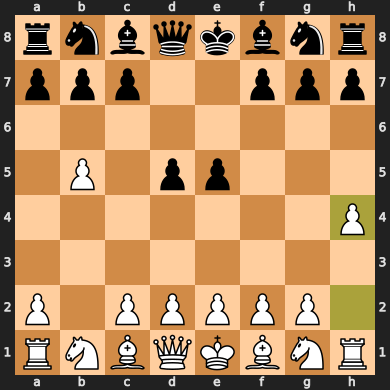

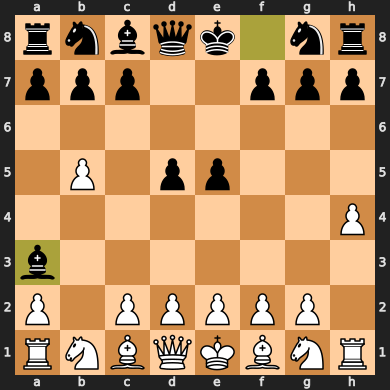

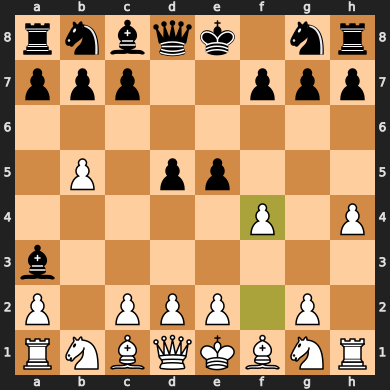

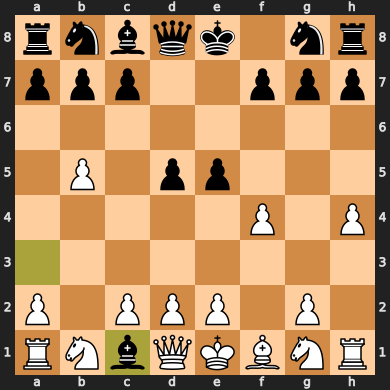

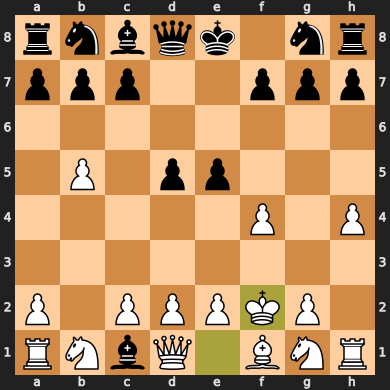

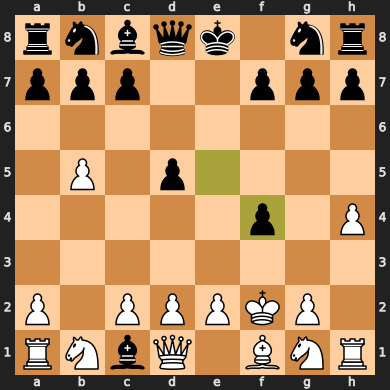

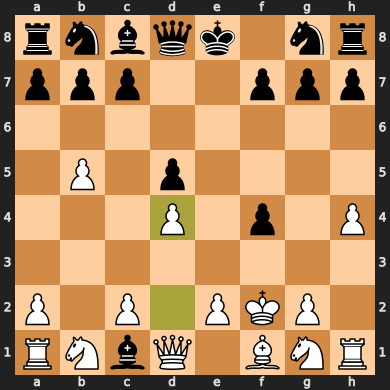

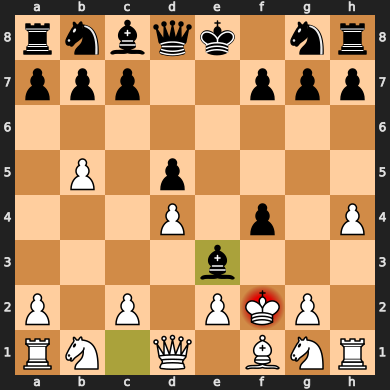

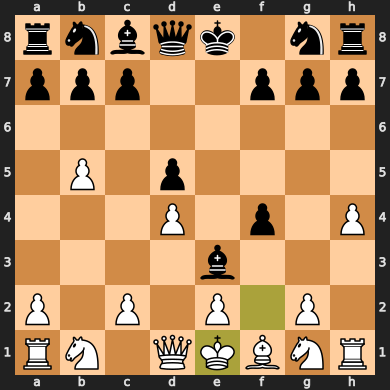

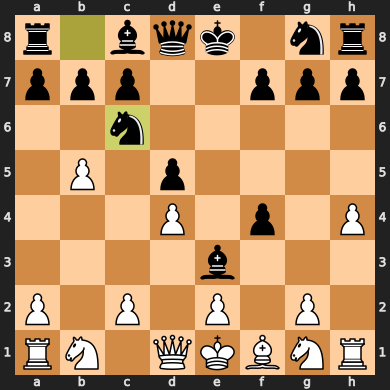

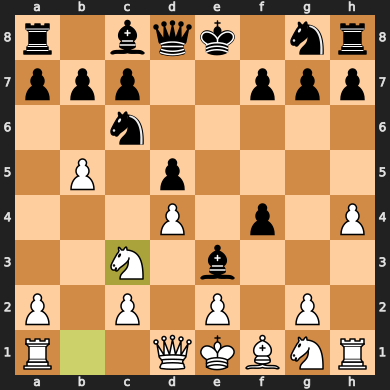

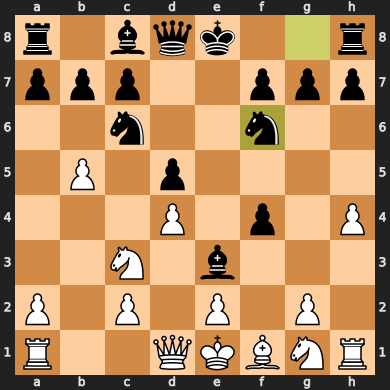

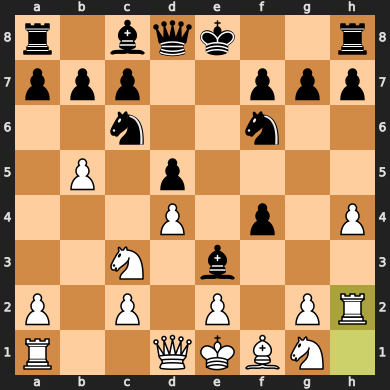

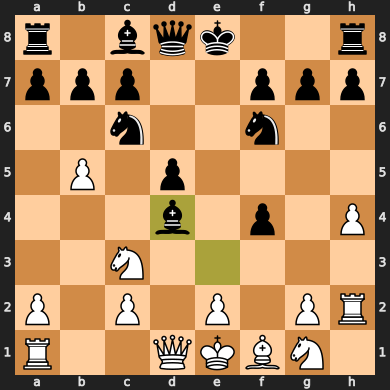

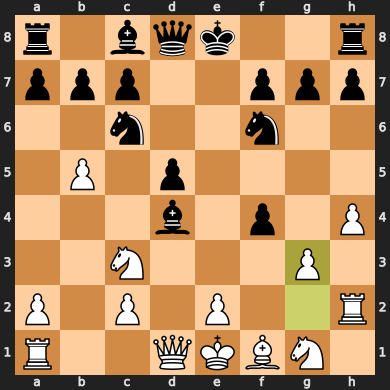

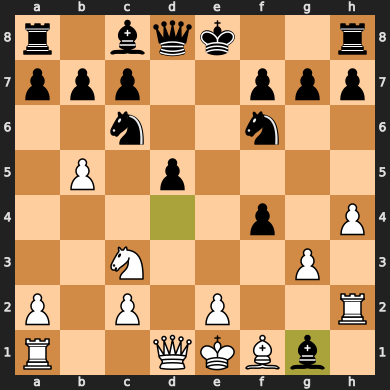

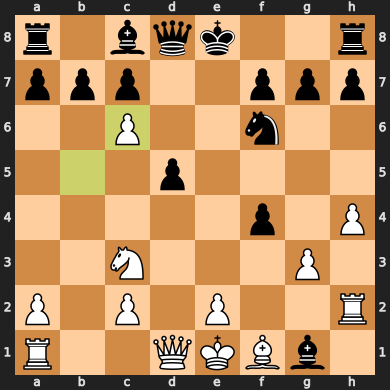

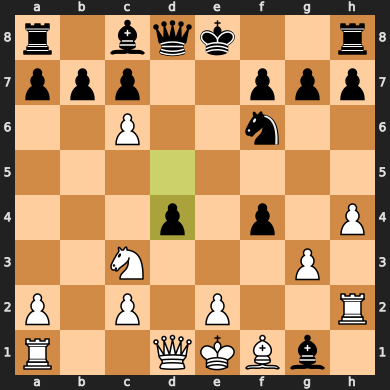

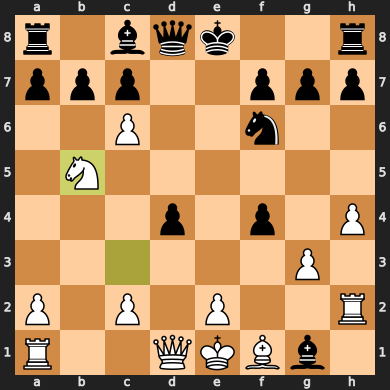

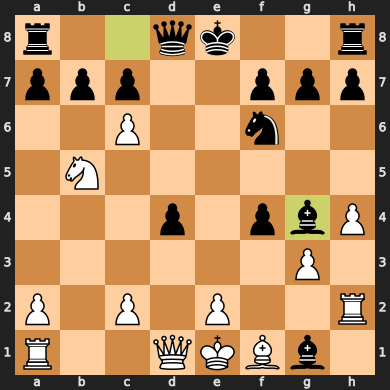

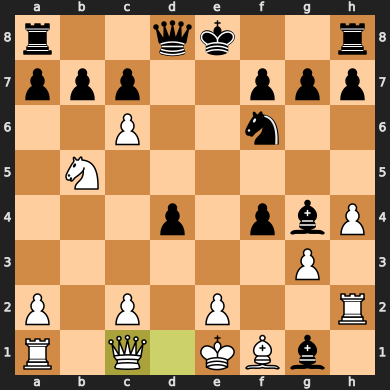

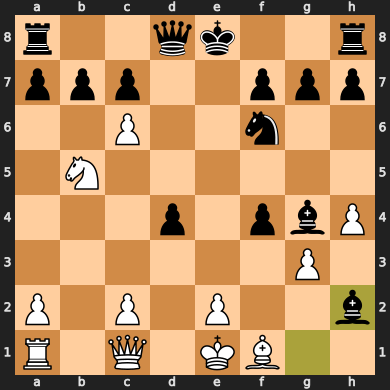

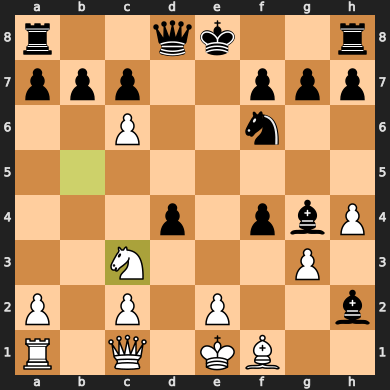

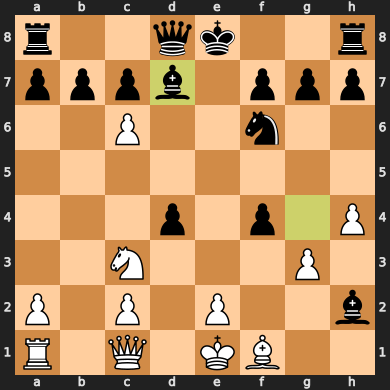

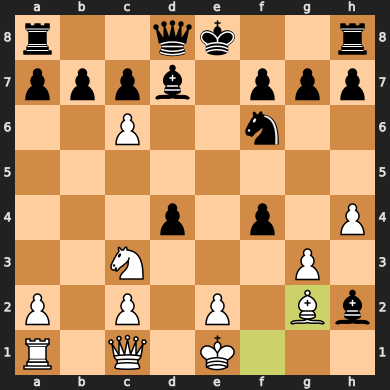

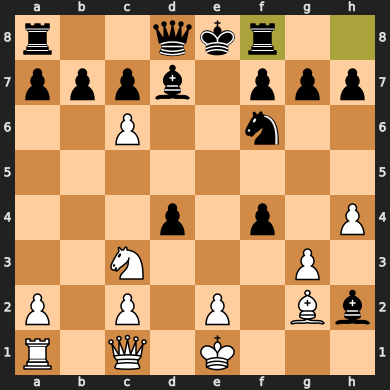

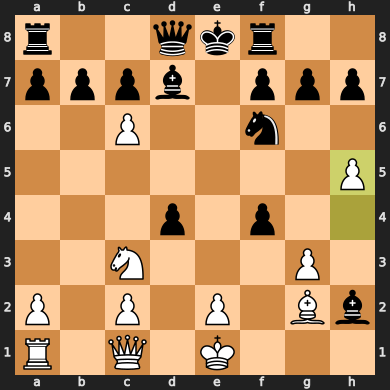

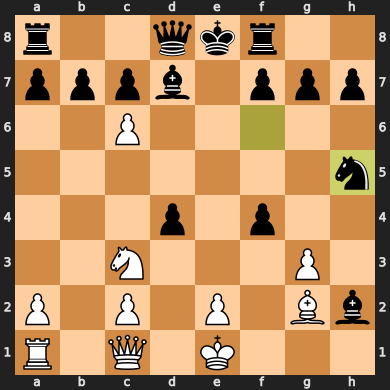

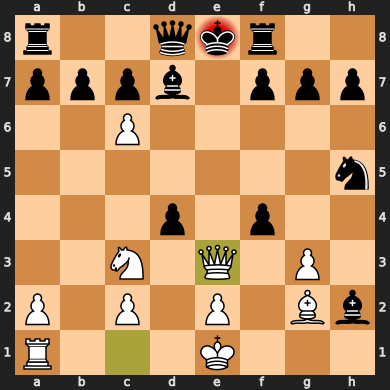

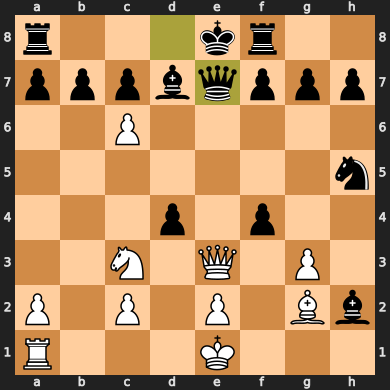

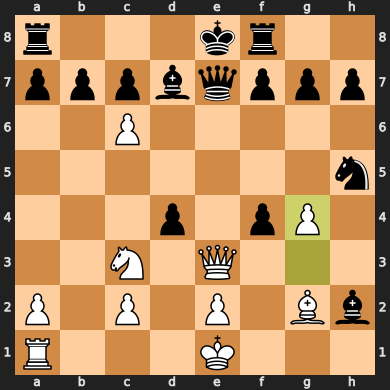

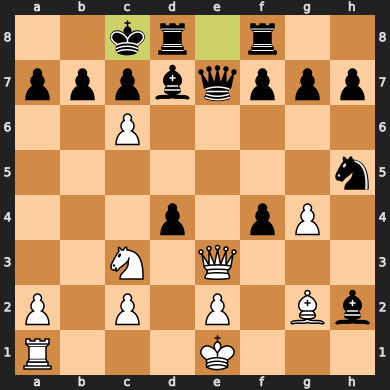

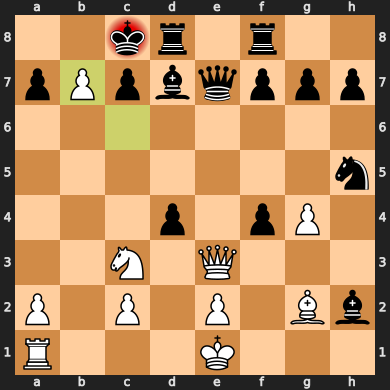

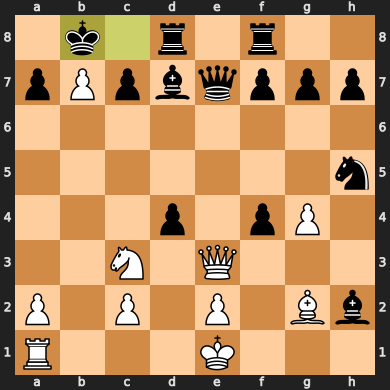

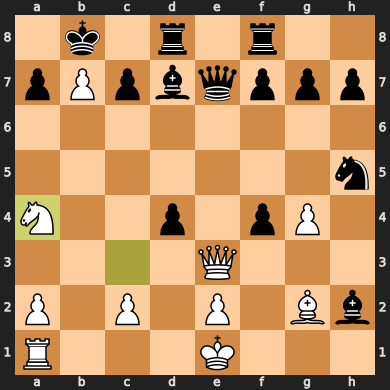

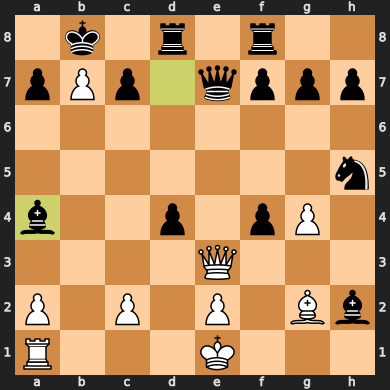

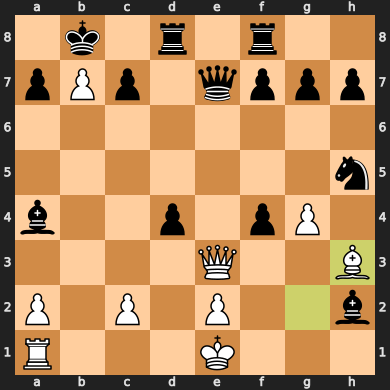

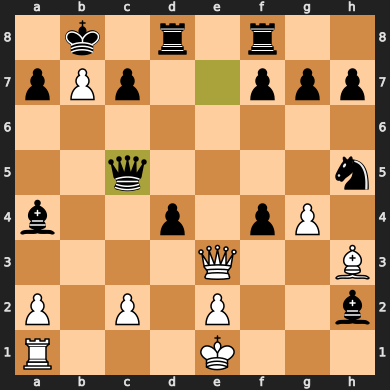

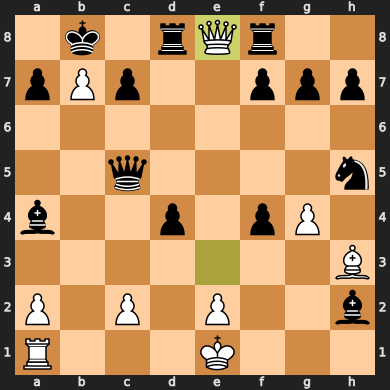

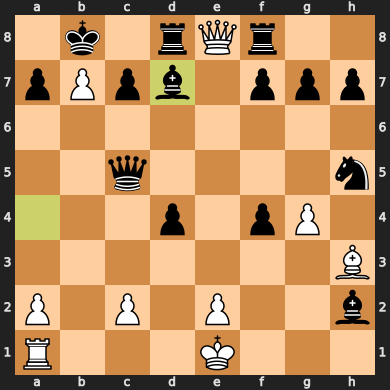

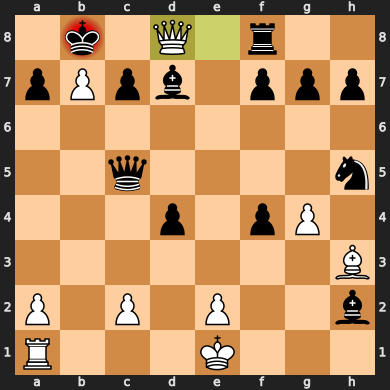

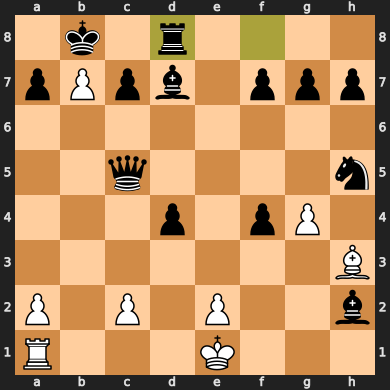

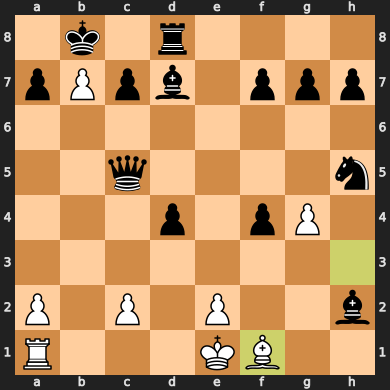

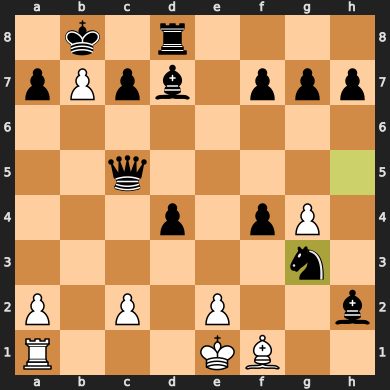

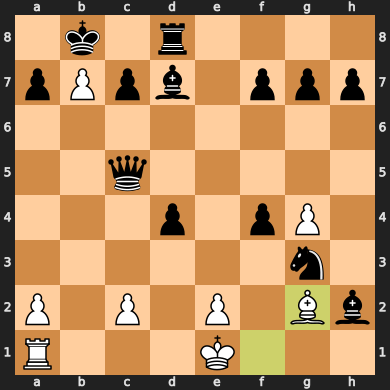

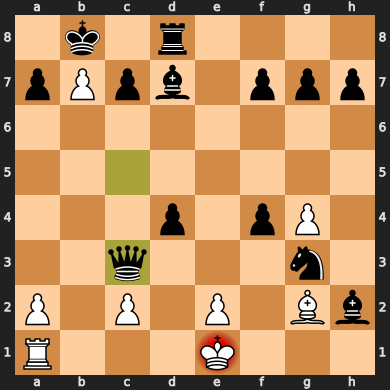

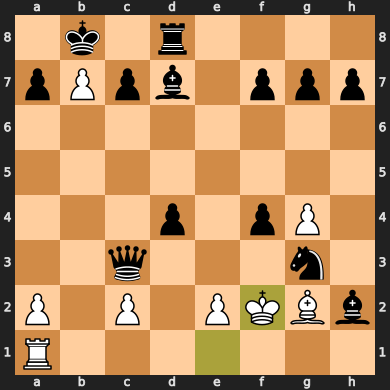

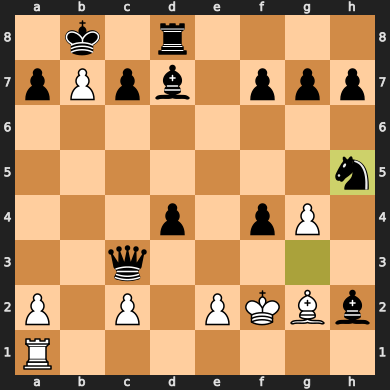

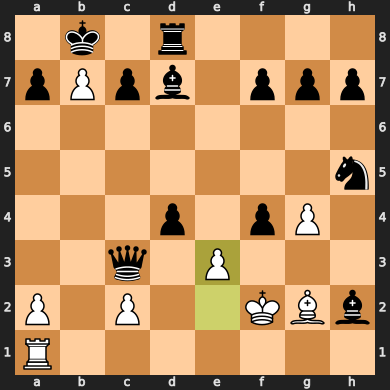

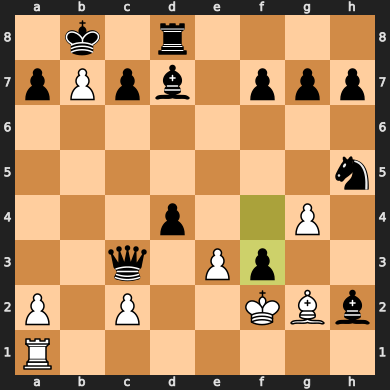

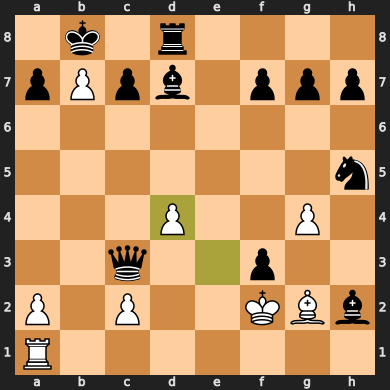

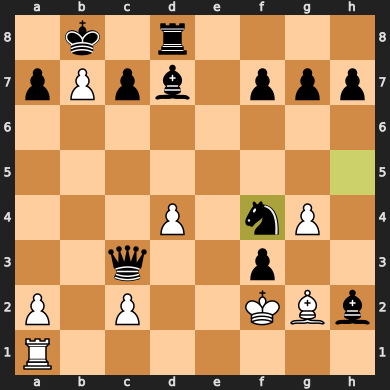

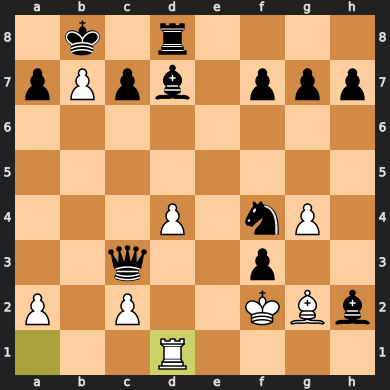

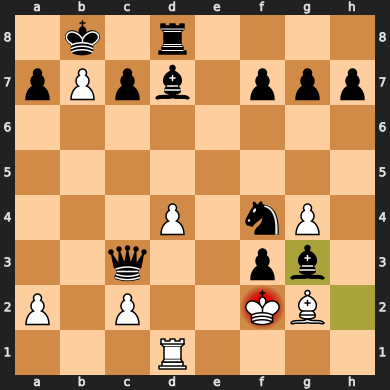

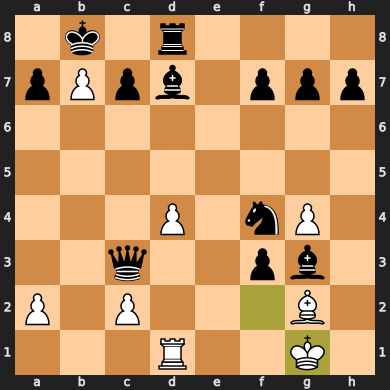

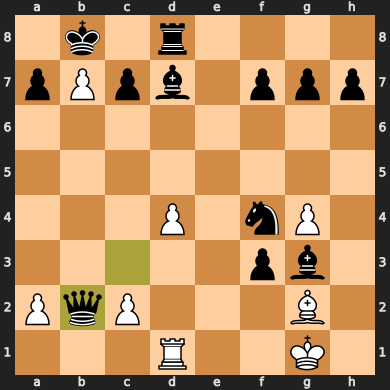

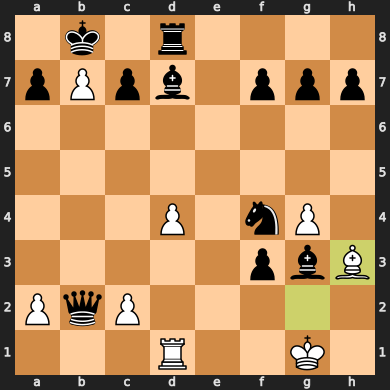

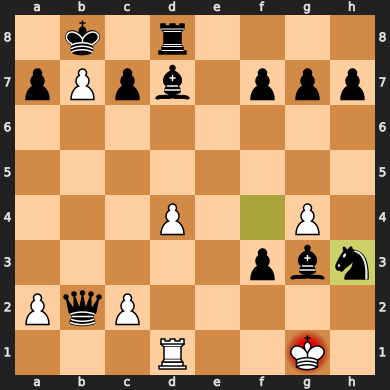

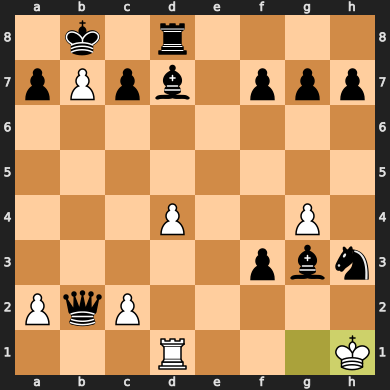

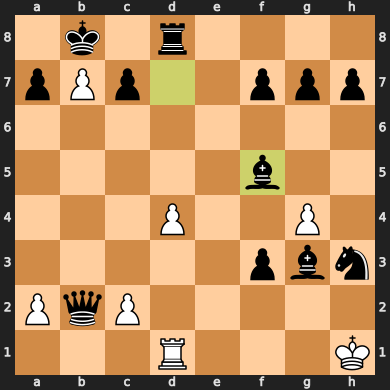

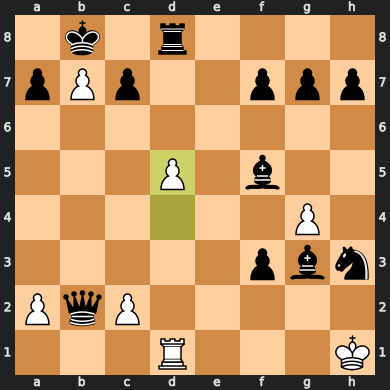

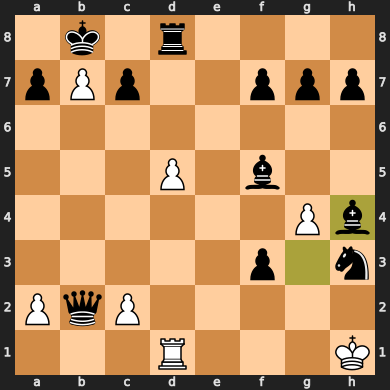

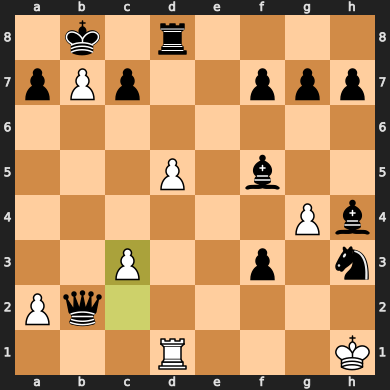

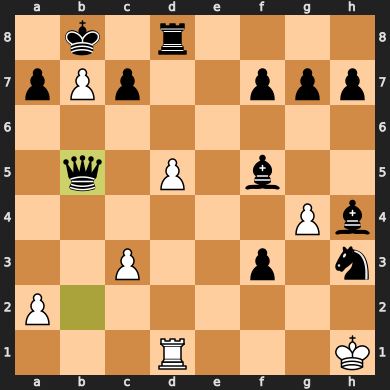

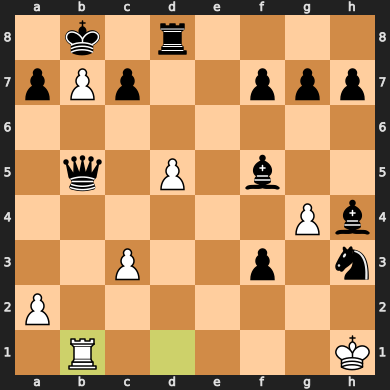

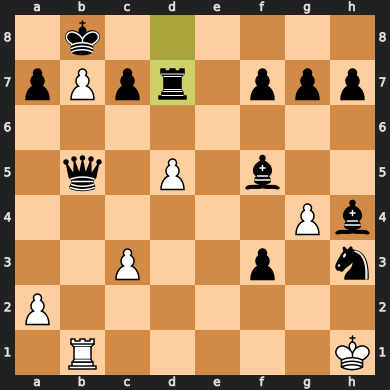

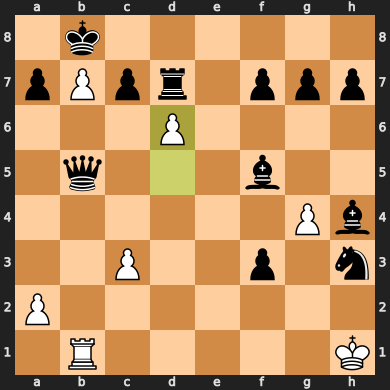

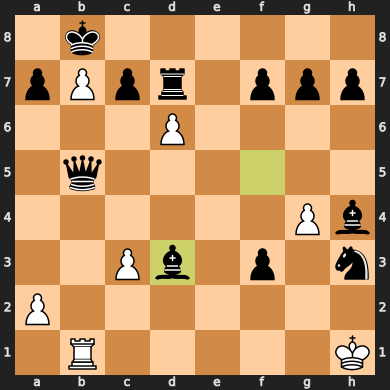

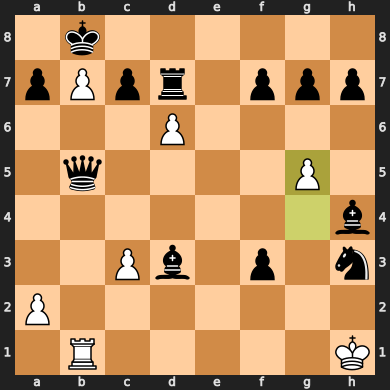

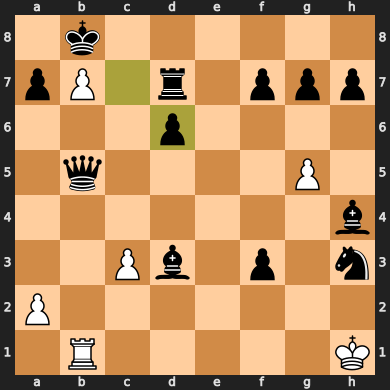

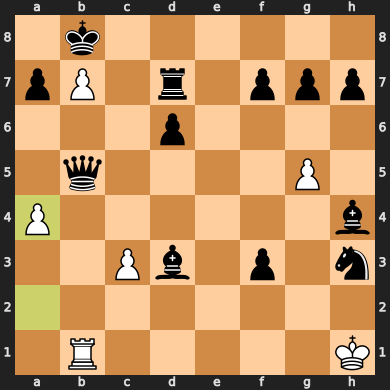

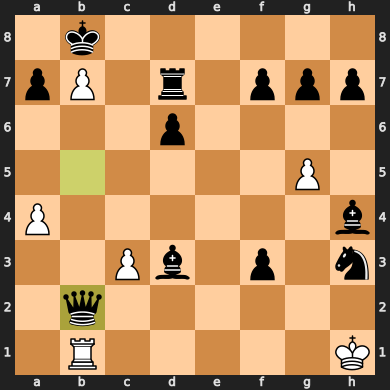

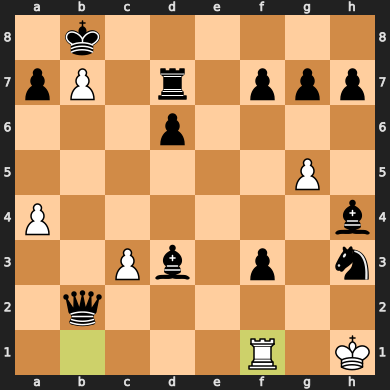

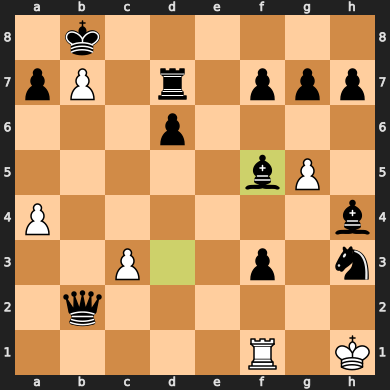

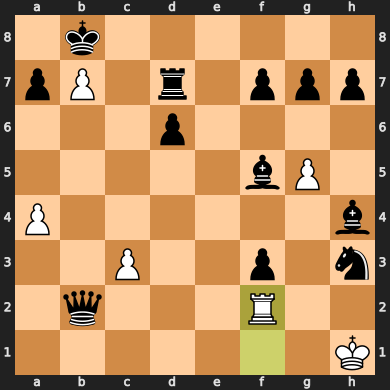

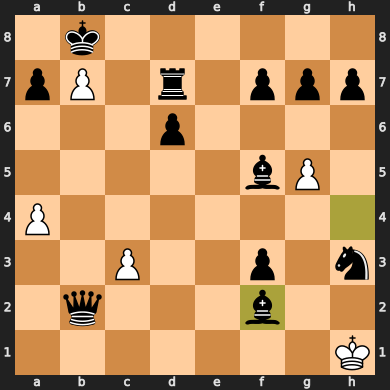

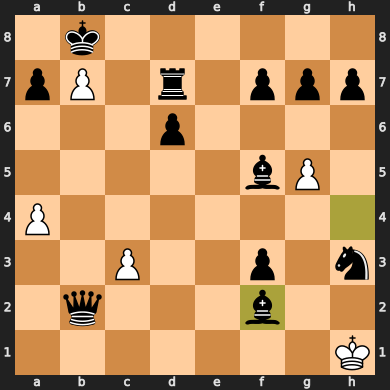

In [54]:
play_game(random_agent, model_agent, verbose=True)